In [1]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

##############################################################################
#
# Global Parameters
#
######################

'''We can setup some parameters to control the operation of the program'''
#parameters
max_turns   = 1000
max_satf    = 100
min_satf    = 0
env_height  = 100
env_width   = 100
epsilon = 0.5

#Building arrays
building_types = ['power plants', 'police stations', 'subway stations', 'bus stations', 'airports', 'schools', 'parks', 'sports facilities', 'zoos', 'commercial districts', 'hospitals']
effect_list = ['pollution_health','entertainment','education','jobs','crime']

#Load Building Effects
effects=[]
file1 = csv.reader(open('Building_Effects.csv', 'r'), delimiter=',', quotechar='"')
file1.__next__()
for row in file1:
    temp=[]
    for i in range(len(row)):
        if i==0:
            temp.append(row[i])
        elif row[i]=='':
            temp.append(0)
        else:
            temp.append(float(row[i]))
    effects.append(temp)

In [2]:
print(building_types, '\n')
print(effects)

['power plants', 'police stations', 'subway stations', 'bus stations', 'airports', 'schools', 'parks', 'sports facilities', 'zoos', 'commercial districts', 'hospitals'] 

[['pollution_health', 3.0, 0, -1.0, -1.0, 2.0, 0, 0, 0, 0, 1.0, -2.0], ['entertainment', 0, -2.0, 0, 0, 0, 0, 2.0, 3.0, 1.0, -2.0, 0], ['education', 0, 0, 0, 0, 0, 3.0, 0, -1.0, 0, 0, 0], ['jobs', 1.0, 1.0, 0, 0, 2.0, 0, -2.0, -2.0, 0, 3.0, 0], ['crime', 0, -2.0, 0, 0, 0, 0, 0, 1.0, 0, 1.0, 0]]


In [3]:
##############################################################################
#
# Define Classes
#
######################

'''Don't change this cell'''

 # 1) Need agent class
 # 2) Need building class
 # 3) Need Environment

class Agent:
    def __init__(self):
        self.row_cnt=0

    def get_row_cnt():
        return row_cnt
          

In [4]:
#############################################################################
#
# Player Agents
#
#######################

'''Our player agents probably need some internal variables so it know the history of actions, current actions, 
   what the current game state is, etc. ... also needs some functions to sense the environment.  It needs some functions
   for different actions, like building new building or destroying existing ones'''

class Player(Agent):    
    #curr_loc=[]
    #curr_act
    #action_hist = []

    
    def __init__(self, n):
        '''Have to initialize it'''
        self.Player_ID = n
        """always good to assign a unique identifier"""
        self.curr_act=None
        """Current action"""
        self.action_hist = []
        """Keep history of actions"""
    
    def Build(self):
        '''Building stuff could be one possible action, for instance, many others'''
        building_type_ID = random.randint(1, len(building_types))
        return building_type_ID
        
    def Destroy(self, buildings):
        '''Destroying stuff could be another possible action, if there are negative effects'''
        building_type_ID = -(random.randint(1, len(building_types)))
        if buildings[abs(building_type_ID)-1] == 0:
            return None
        else:
            return building_type_ID

    def Choose_Action(self, epsilon, buildings, building_cnt):
        '''Picks action based on state of the world or some model'''
        probability = np.random.random()
        if probability >= epsilon:
            action = self.Build()
        elif building_cnt != 0:
            action = self.Destroy(buildings)
        else:
            action = None
                        
        #Set new action
        self.curr_act=action
        self.action_hist.append(action)
        
        return action
    


class Citizen(Agent):    
    #curr_satf
    #pref_list
    
    def __init__(self, n):
        '''Have to initialize it'''
        self.Citizen_ID = n
        """always good to assign a unique identifier"""
        self.curr_satf=50
        """start citizens at midpoint satisfaction level"""
        self.pref_list = [random.random() for col in range(len(effect_list))]
        '''Every citizen should have a preference for which effects that matter most to them (e.g. education)'''
       
    def update_satf(self, effects_list):
        '''Each turn should update satisfaction, based on some logic'''
        self.curr_satf = 50 + sum([a * b for a, b in zip(self.pref_list, effects_list)])
        if self.curr_satf >= 100:
            return 100
        else:
            return self.curr_satf

In [5]:
#############################################################################
#
# Environment
#
#######################

'''Need to account for all the things in the environment (e.g.  citizens, buildings, building effects), at some 
   abstract level. Also need a "map" of the world or some sort of grid system to track location/states/etc'''

class Env():
    #states=[]
    #pollution_health
    #entertainment
    #education
    #jobs
    #crime

    def __init__(self):
        
        self.buildings = np.zeros(len(building_types))
        self.building_cnt = 0
        self.pollution_health = 0
        self.entertainment = 0
        self.education = 0
        self.jobs = 0
        self.crime = 0
        self.effects_list = [self.pollution_health, self.entertainment, self.education, self.jobs, self.crime]
        
        self.citizen_ID = 1
        self.citizen_cnt = 1
        self.citizen_list = [Citizen(1), ]
        self.cur_satf_mean = 50
        
        self.satf_hist = []
        self.citizen_hist = []
        
    def update_env(self, effects, mayor_action):
        '''Each turn the environment should update'''
        self.cur_satf_sum = 0
        
        if mayor_action == None:
            pass
        elif mayor_action > 0:
            self.pollution_health += effects[0][mayor_action]
            self.entertainment += effects[1][mayor_action]
            self.education += effects[2][mayor_action]
            self.jobs += effects[3][mayor_action]
            self.crime += effects[4][mayor_action]
            self.building_cnt+=1
            self.buildings[mayor_action-1]+=1
        else:
            self.pollution_health -= effects[0][abs(mayor_action)]
            self.entertainment -= effects[1][abs(mayor_action)]
            self.education -= effects[2][abs(mayor_action)]
            self.jobs -= effects[3][abs(mayor_action)]
            self.crime -= effects[4][abs(mayor_action)]
            self.building_cnt -= 1
            self.buildings[abs(mayor_action)-1]-=1
        
        self.effects_list = [self.pollution_health, self.entertainment, self.education, self.jobs, self.crime]
        
        for citizen in self.citizen_list:
            self.tmp_satf = citizen.update_satf(self.effects_list)
            if self.tmp_satf < 30:
                if self.citizen_cnt > 1:
                    del self.citizen_list[self.citizen_list.index(citizen)]
                    self.citizen_cnt-=1
            else:
                self.cur_satf_sum += self.tmp_satf
                
        self.cur_satf_mean = round(self.cur_satf_sum/self.citizen_cnt, 2)
        
        if self.cur_satf_mean >= 70:
            for i in range(random.randint(1, 11)):
                self.citizen_ID += 1
                self.citizen_cnt += 1
                self.citizen_list.append(Citizen(self.citizen_ID))
        
        self.satf_hist.append(self.cur_satf_mean)
        self.citizen_hist.append(self.citizen_cnt)

In [6]:
#############################################################################
#
# Main Program
#
#######################



def main():
    # Start the program
    turn = 0
    mayor = Player(1)
    env = Env()
    
    while turn < max_turns:
        
        '''stuff happens here'''
        env.update_env(effects, mayor.Choose_Action(epsilon, env.buildings, env.building_cnt))
        
        print('Turn : ', turn+1)
        print('Current Satisfaction : ', env.cur_satf_mean)
        print('Current Population : ', env.citizen_cnt)
        print('power plants : ', env.buildings[0])
        print('police stations : ', env.buildings[1])
        print('subway stations : ', env.buildings[2])
        print('bus stations : ', env.buildings[3])
        print('airports : ', env.buildings[4])
        print('schools : ', env.buildings[5])
        print('parks : ', env.buildings[6])
        print('sports facility : ', env.buildings[7])
        print('zoos : ', env.buildings[8])
        print('commercial district : ', env.buildings[9])
        print('hospitals : ', env.buildings[10])
        print('\n')
        turn+=1
    
    print("Final results")
    
    plt.plot(range(len(env.citizen_hist)), env.citizen_hist)
    plt.plot(range(len(env.satf_hist)), env.satf_hist)
    plt.legend(['population','satisfaction'])
    
    print("Max population : ", max(env.citizen_hist), "  ", "Min population : ", min(env.citizen_hist))
    print("Max satisfaction : ", max(env.satf_hist), "  ", "Min satisfaction : ", min(env.satf_hist))

Turn :  1
Current Satisfaction :  50.0
Current Population :  1
power plants :  0.0
police stations :  0.0
subway stations :  0.0
bus stations :  0.0
airports :  0.0
schools :  0.0
parks :  0.0
sports facility :  0.0
zoos :  0.0
commercial district :  0.0
hospitals :  0.0


Turn :  2
Current Satisfaction :  50.0
Current Population :  1
power plants :  0.0
police stations :  0.0
subway stations :  0.0
bus stations :  0.0
airports :  0.0
schools :  0.0
parks :  0.0
sports facility :  0.0
zoos :  0.0
commercial district :  0.0
hospitals :  0.0


Turn :  3
Current Satisfaction :  50.0
Current Population :  1
power plants :  0.0
police stations :  0.0
subway stations :  0.0
bus stations :  0.0
airports :  0.0
schools :  0.0
parks :  0.0
sports facility :  0.0
zoos :  0.0
commercial district :  0.0
hospitals :  0.0


Turn :  4
Current Satisfaction :  50.0
Current Population :  1
power plants :  0.0
police stations :  0.0
subway stations :  0.0
bus stations :  0.0
airports :  0.0
schools :  0.

parks :  0.0
sports facility :  0.0
zoos :  1.0
commercial district :  2.0
hospitals :  0.0


Turn :  35
Current Satisfaction :  44.37
Current Population :  1
power plants :  0.0
police stations :  3.0
subway stations :  0.0
bus stations :  0.0
airports :  0.0
schools :  1.0
parks :  0.0
sports facility :  0.0
zoos :  1.0
commercial district :  2.0
hospitals :  0.0


Turn :  36
Current Satisfaction :  45.4
Current Population :  1
power plants :  0.0
police stations :  3.0
subway stations :  0.0
bus stations :  0.0
airports :  0.0
schools :  2.0
parks :  0.0
sports facility :  0.0
zoos :  1.0
commercial district :  2.0
hospitals :  0.0


Turn :  37
Current Satisfaction :  44.96
Current Population :  1
power plants :  0.0
police stations :  3.0
subway stations :  0.0
bus stations :  0.0
airports :  0.0
schools :  2.0
parks :  0.0
sports facility :  0.0
zoos :  1.0
commercial district :  1.0
hospitals :  0.0


Turn :  38
Current Satisfaction :  47.36
Current Population :  1
power plants :

hospitals :  0.0


Turn :  71
Current Satisfaction :  63.09
Current Population :  1
power plants :  2.0
police stations :  2.0
subway stations :  2.0
bus stations :  1.0
airports :  1.0
schools :  3.0
parks :  0.0
sports facility :  2.0
zoos :  4.0
commercial district :  2.0
hospitals :  0.0


Turn :  72
Current Satisfaction :  62.2
Current Population :  1
power plants :  2.0
police stations :  2.0
subway stations :  3.0
bus stations :  1.0
airports :  1.0
schools :  3.0
parks :  0.0
sports facility :  2.0
zoos :  4.0
commercial district :  2.0
hospitals :  0.0


Turn :  73
Current Satisfaction :  62.64
Current Population :  1
power plants :  2.0
police stations :  2.0
subway stations :  3.0
bus stations :  1.0
airports :  1.0
schools :  3.0
parks :  0.0
sports facility :  2.0
zoos :  4.0
commercial district :  3.0
hospitals :  0.0


Turn :  74
Current Satisfaction :  65.48
Current Population :  1
power plants :  2.0
police stations :  1.0
subway stations :  3.0
bus stations :  1.0
air

zoos :  6.0
commercial district :  4.0
hospitals :  3.0


Turn :  109
Current Satisfaction :  58.04
Current Population :  1
power plants :  1.0
police stations :  0.0
subway stations :  6.0
bus stations :  1.0
airports :  1.0
schools :  0.0
parks :  1.0
sports facility :  2.0
zoos :  6.0
commercial district :  4.0
hospitals :  3.0


Turn :  110
Current Satisfaction :  59.82
Current Population :  1
power plants :  1.0
police stations :  0.0
subway stations :  6.0
bus stations :  1.0
airports :  1.0
schools :  0.0
parks :  1.0
sports facility :  2.0
zoos :  6.0
commercial district :  4.0
hospitals :  2.0


Turn :  111
Current Satisfaction :  61.59
Current Population :  1
power plants :  1.0
police stations :  0.0
subway stations :  6.0
bus stations :  1.0
airports :  1.0
schools :  0.0
parks :  1.0
sports facility :  2.0
zoos :  6.0
commercial district :  4.0
hospitals :  1.0


Turn :  112
Current Satisfaction :  62.62
Current Population :  1
power plants :  1.0
police stations :  0.0
su

police stations :  0.0
subway stations :  5.0
bus stations :  0.0
airports :  2.0
schools :  2.0
parks :  1.0
sports facility :  1.0
zoos :  5.0
commercial district :  6.0
hospitals :  0.0


Turn :  147
Current Satisfaction :  65.88
Current Population :  1
power plants :  1.0
police stations :  0.0
subway stations :  5.0
bus stations :  0.0
airports :  2.0
schools :  1.0
parks :  1.0
sports facility :  1.0
zoos :  5.0
commercial district :  6.0
hospitals :  0.0


Turn :  148
Current Satisfaction :  63.3
Current Population :  1
power plants :  1.0
police stations :  0.0
subway stations :  5.0
bus stations :  0.0
airports :  2.0
schools :  1.0
parks :  1.0
sports facility :  0.0
zoos :  5.0
commercial district :  6.0
hospitals :  0.0


Turn :  149
Current Satisfaction :  60.45
Current Population :  1
power plants :  1.0
police stations :  1.0
subway stations :  5.0
bus stations :  0.0
airports :  2.0
schools :  1.0
parks :  1.0
sports facility :  0.0
zoos :  5.0
commercial district :  6.

power plants :  1.0
police stations :  0.0
subway stations :  2.0
bus stations :  2.0
airports :  3.0
schools :  0.0
parks :  0.0
sports facility :  0.0
zoos :  5.0
commercial district :  6.0
hospitals :  1.0


Turn :  183
Current Satisfaction :  66.29
Current Population :  80
power plants :  0.0
police stations :  0.0
subway stations :  2.0
bus stations :  2.0
airports :  3.0
schools :  0.0
parks :  0.0
sports facility :  0.0
zoos :  5.0
commercial district :  6.0
hospitals :  1.0


Turn :  184
Current Satisfaction :  68.08
Current Population :  80
power plants :  0.0
police stations :  0.0
subway stations :  2.0
bus stations :  2.0
airports :  3.0
schools :  0.0
parks :  0.0
sports facility :  0.0
zoos :  5.0
commercial district :  7.0
hospitals :  1.0


Turn :  185
Current Satisfaction :  69.21
Current Population :  80
power plants :  0.0
police stations :  0.0
subway stations :  2.0
bus stations :  2.0
airports :  3.0
schools :  0.0
parks :  0.0
sports facility :  0.0
zoos :  5.0
c

commercial district :  9.0
hospitals :  1.0


Turn :  218
Current Satisfaction :  72.96
Current Population :  198
power plants :  2.0
police stations :  0.0
subway stations :  2.0
bus stations :  2.0
airports :  2.0
schools :  0.0
parks :  3.0
sports facility :  3.0
zoos :  4.0
commercial district :  9.0
hospitals :  1.0


Turn :  219
Current Satisfaction :  71.23
Current Population :  209
power plants :  2.0
police stations :  0.0
subway stations :  2.0
bus stations :  2.0
airports :  2.0
schools :  0.0
parks :  3.0
sports facility :  3.0
zoos :  4.0
commercial district :  8.0
hospitals :  1.0


Turn :  220
Current Satisfaction :  73.19
Current Population :  210
power plants :  3.0
police stations :  0.0
subway stations :  2.0
bus stations :  2.0
airports :  2.0
schools :  0.0
parks :  3.0
sports facility :  3.0
zoos :  4.0
commercial district :  8.0
hospitals :  1.0


Turn :  221
Current Satisfaction :  71.02
Current Population :  221
power plants :  2.0
police stations :  0.0
subway

Turn :  252
Current Satisfaction :  72.69
Current Population :  386
power plants :  1.0
police stations :  0.0
subway stations :  1.0
bus stations :  1.0
airports :  3.0
schools :  2.0
parks :  6.0
sports facility :  1.0
zoos :  6.0
commercial district :  6.0
hospitals :  0.0


Turn :  253
Current Satisfaction :  73.15
Current Population :  390
power plants :  1.0
police stations :  0.0
subway stations :  1.0
bus stations :  1.0
airports :  3.0
schools :  2.0
parks :  6.0
sports facility :  2.0
zoos :  6.0
commercial district :  6.0
hospitals :  0.0


Turn :  254
Current Satisfaction :  73.11
Current Population :  391
power plants :  1.0
police stations :  0.0
subway stations :  1.0
bus stations :  1.0
airports :  3.0
schools :  2.0
parks :  7.0
sports facility :  2.0
zoos :  6.0
commercial district :  6.0
hospitals :  0.0


Turn :  255
Current Satisfaction :  71.05
Current Population :  395
power plants :  0.0
police stations :  0.0
subway stations :  1.0
bus stations :  1.0
airports 

Current Satisfaction :  64.04
Current Population :  514
power plants :  1.0
police stations :  1.0
subway stations :  1.0
bus stations :  2.0
airports :  0.0
schools :  0.0
parks :  7.0
sports facility :  4.0
zoos :  5.0
commercial district :  7.0
hospitals :  0.0


Turn :  286
Current Satisfaction :  64.03
Current Population :  514
power plants :  1.0
police stations :  1.0
subway stations :  1.0
bus stations :  2.0
airports :  0.0
schools :  0.0
parks :  8.0
sports facility :  4.0
zoos :  5.0
commercial district :  7.0
hospitals :  0.0


Turn :  287
Current Satisfaction :  66.11
Current Population :  514
power plants :  2.0
police stations :  1.0
subway stations :  1.0
bus stations :  2.0
airports :  0.0
schools :  0.0
parks :  8.0
sports facility :  4.0
zoos :  5.0
commercial district :  7.0
hospitals :  0.0


Turn :  288
Current Satisfaction :  66.11
Current Population :  514
power plants :  2.0
police stations :  1.0
subway stations :  1.0
bus stations :  2.0
airports :  0.0
schoo

subway stations :  0.0
bus stations :  4.0
airports :  0.0
schools :  1.0
parks :  8.0
sports facility :  4.0
zoos :  6.0
commercial district :  8.0
hospitals :  1.0


Turn :  319
Current Satisfaction :  66.76
Current Population :  524
power plants :  3.0
police stations :  4.0
subway stations :  0.0
bus stations :  4.0
airports :  0.0
schools :  1.0
parks :  8.0
sports facility :  4.0
zoos :  6.0
commercial district :  8.0
hospitals :  0.0


Turn :  320
Current Satisfaction :  66.75
Current Population :  524
power plants :  3.0
police stations :  4.0
subway stations :  0.0
bus stations :  4.0
airports :  0.0
schools :  1.0
parks :  9.0
sports facility :  4.0
zoos :  6.0
commercial district :  8.0
hospitals :  0.0


Turn :  321
Current Satisfaction :  66.73
Current Population :  524
power plants :  3.0
police stations :  4.0
subway stations :  0.0
bus stations :  4.0
airports :  0.0
schools :  1.0
parks :  10.0
sports facility :  4.0
zoos :  6.0
commercial district :  8.0
hospitals :  

subway stations :  0.0
bus stations :  2.0
airports :  0.0
schools :  4.0
parks :  14.0
sports facility :  4.0
zoos :  5.0
commercial district :  9.0
hospitals :  2.0


Turn :  355
Current Satisfaction :  72.71
Current Population :  646
power plants :  2.0
police stations :  3.0
subway stations :  0.0
bus stations :  2.0
airports :  1.0
schools :  4.0
parks :  14.0
sports facility :  4.0
zoos :  5.0
commercial district :  9.0
hospitals :  2.0


Turn :  356
Current Satisfaction :  73.19
Current Population :  650
power plants :  2.0
police stations :  3.0
subway stations :  0.0
bus stations :  2.0
airports :  1.0
schools :  4.0
parks :  14.0
sports facility :  4.0
zoos :  6.0
commercial district :  9.0
hospitals :  2.0


Turn :  357
Current Satisfaction :  72.68
Current Population :  651
power plants :  2.0
police stations :  3.0
subway stations :  0.0
bus stations :  3.0
airports :  1.0
schools :  4.0
parks :  14.0
sports facility :  4.0
zoos :  6.0
commercial district :  9.0
hospitals 


Turn :  386
Current Satisfaction :  68.14
Current Population :  772
power plants :  2.0
police stations :  2.0
subway stations :  1.0
bus stations :  2.0
airports :  0.0
schools :  3.0
parks :  15.0
sports facility :  3.0
zoos :  5.0
commercial district :  8.0
hospitals :  2.0


Turn :  387
Current Satisfaction :  70.19
Current Population :  775
power plants :  3.0
police stations :  2.0
subway stations :  1.0
bus stations :  2.0
airports :  0.0
schools :  3.0
parks :  15.0
sports facility :  3.0
zoos :  5.0
commercial district :  8.0
hospitals :  2.0


Turn :  388
Current Satisfaction :  70.68
Current Population :  777
power plants :  3.0
police stations :  2.0
subway stations :  1.0
bus stations :  2.0
airports :  0.0
schools :  3.0
parks :  15.0
sports facility :  3.0
zoos :  6.0
commercial district :  8.0
hospitals :  2.0


Turn :  389
Current Satisfaction :  70.14
Current Population :  782
power plants :  3.0
police stations :  2.0
subway stations :  2.0
bus stations :  2.0
airpo

airports :  1.0
schools :  3.0
parks :  16.0
sports facility :  3.0
zoos :  6.0
commercial district :  6.0
hospitals :  3.0


Turn :  418
Current Satisfaction :  66.22
Current Population :  850
power plants :  4.0
police stations :  3.0
subway stations :  2.0
bus stations :  3.0
airports :  0.0
schools :  3.0
parks :  16.0
sports facility :  3.0
zoos :  6.0
commercial district :  6.0
hospitals :  3.0


Turn :  419
Current Satisfaction :  64.73
Current Population :  850
power plants :  4.0
police stations :  3.0
subway stations :  2.0
bus stations :  3.0
airports :  0.0
schools :  3.0
parks :  16.0
sports facility :  3.0
zoos :  6.0
commercial district :  5.0
hospitals :  3.0


Turn :  420
Current Satisfaction :  65.22
Current Population :  850
power plants :  4.0
police stations :  3.0
subway stations :  2.0
bus stations :  3.0
airports :  0.0
schools :  3.0
parks :  16.0
sports facility :  3.0
zoos :  7.0
commercial district :  5.0
hospitals :  3.0


Turn :  421
Current Satisfaction :

airports :  4.0
schools :  1.0
parks :  21.0
sports facility :  4.0
zoos :  7.0
commercial district :  3.0
hospitals :  4.0


Turn :  454
Current Satisfaction :  67.57
Current Population :  842
power plants :  4.0
police stations :  3.0
subway stations :  0.0
bus stations :  0.0
airports :  3.0
schools :  1.0
parks :  21.0
sports facility :  4.0
zoos :  7.0
commercial district :  3.0
hospitals :  4.0


Turn :  455
Current Satisfaction :  65.53
Current Population :  841
power plants :  4.0
police stations :  3.0
subway stations :  0.0
bus stations :  0.0
airports :  2.0
schools :  1.0
parks :  21.0
sports facility :  4.0
zoos :  7.0
commercial district :  3.0
hospitals :  4.0


Turn :  456
Current Satisfaction :  65.63
Current Population :  841
power plants :  4.0
police stations :  3.0
subway stations :  0.0
bus stations :  0.0
airports :  2.0
schools :  1.0
parks :  20.0
sports facility :  4.0
zoos :  7.0
commercial district :  3.0
hospitals :  4.0


Turn :  457
Current Satisfaction :

Current Satisfaction :  67.67
Current Population :  815
power plants :  4.0
police stations :  3.0
subway stations :  0.0
bus stations :  0.0
airports :  0.0
schools :  3.0
parks :  20.0
sports facility :  4.0
zoos :  9.0
commercial district :  3.0
hospitals :  3.0


Turn :  487
Current Satisfaction :  68.16
Current Population :  815
power plants :  4.0
police stations :  3.0
subway stations :  0.0
bus stations :  0.0
airports :  0.0
schools :  3.0
parks :  20.0
sports facility :  4.0
zoos :  10.0
commercial district :  3.0
hospitals :  3.0


Turn :  488
Current Satisfaction :  68.16
Current Population :  815
power plants :  4.0
police stations :  3.0
subway stations :  0.0
bus stations :  0.0
airports :  0.0
schools :  3.0
parks :  20.0
sports facility :  4.0
zoos :  10.0
commercial district :  3.0
hospitals :  3.0


Turn :  489
Current Satisfaction :  68.13
Current Population :  815
power plants :  4.0
police stations :  3.0
subway stations :  0.0
bus stations :  0.0
airports :  0.0


zoos :  9.0
commercial district :  3.0
hospitals :  1.0


Turn :  526
Current Satisfaction :  70.09
Current Population :  840
power plants :  1.0
police stations :  4.0
subway stations :  3.0
bus stations :  2.0
airports :  4.0
schools :  4.0
parks :  23.0
sports facility :  3.0
zoos :  9.0
commercial district :  4.0
hospitals :  1.0


Turn :  527
Current Satisfaction :  70.65
Current Population :  845
power plants :  1.0
police stations :  4.0
subway stations :  3.0
bus stations :  1.0
airports :  4.0
schools :  4.0
parks :  23.0
sports facility :  3.0
zoos :  9.0
commercial district :  4.0
hospitals :  1.0


Turn :  528
Current Satisfaction :  70.18
Current Population :  851
power plants :  1.0
police stations :  4.0
subway stations :  3.0
bus stations :  1.0
airports :  4.0
schools :  4.0
parks :  23.0
sports facility :  2.0
zoos :  9.0
commercial district :  4.0
hospitals :  1.0


Turn :  529
Current Satisfaction :  68.75
Current Population :  851
power plants :  1.0
police station

zoos :  9.0
commercial district :  2.0
hospitals :  0.0


Turn :  564
Current Satisfaction :  70.94
Current Population :  891
power plants :  1.0
police stations :  4.0
subway stations :  1.0
bus stations :  2.0
airports :  5.0
schools :  3.0
parks :  19.0
sports facility :  6.0
zoos :  9.0
commercial district :  2.0
hospitals :  0.0


Turn :  565
Current Satisfaction :  70.48
Current Population :  895
power plants :  1.0
police stations :  4.0
subway stations :  1.0
bus stations :  3.0
airports :  5.0
schools :  3.0
parks :  19.0
sports facility :  6.0
zoos :  9.0
commercial district :  2.0
hospitals :  0.0


Turn :  566
Current Satisfaction :  72.45
Current Population :  903
power plants :  1.0
police stations :  4.0
subway stations :  1.0
bus stations :  3.0
airports :  6.0
schools :  3.0
parks :  19.0
sports facility :  6.0
zoos :  9.0
commercial district :  2.0
hospitals :  0.0


Turn :  567
Current Satisfaction :  71.45
Current Population :  910
power plants :  1.0
police station

subway stations :  3.0
bus stations :  2.0
airports :  7.0
schools :  2.0
parks :  18.0
sports facility :  6.0
zoos :  8.0
commercial district :  4.0
hospitals :  0.0


Turn :  596
Current Satisfaction :  74.15
Current Population :  1060
power plants :  1.0
police stations :  4.0
subway stations :  3.0
bus stations :  3.0
airports :  7.0
schools :  2.0
parks :  18.0
sports facility :  6.0
zoos :  8.0
commercial district :  4.0
hospitals :  0.0


Turn :  597
Current Satisfaction :  75.63
Current Population :  1062
power plants :  1.0
police stations :  4.0
subway stations :  3.0
bus stations :  3.0
airports :  7.0
schools :  3.0
parks :  18.0
sports facility :  6.0
zoos :  8.0
commercial district :  4.0
hospitals :  0.0


Turn :  598
Current Satisfaction :  76.12
Current Population :  1069
power plants :  1.0
police stations :  4.0
subway stations :  2.0
bus stations :  3.0
airports :  7.0
schools :  3.0
parks :  18.0
sports facility :  6.0
zoos :  8.0
commercial district :  4.0
hospita

hospitals :  1.0


Turn :  632
Current Satisfaction :  73.21
Current Population :  1317
power plants :  1.0
police stations :  6.0
subway stations :  0.0
bus stations :  4.0
airports :  3.0
schools :  3.0
parks :  17.0
sports facility :  7.0
zoos :  8.0
commercial district :  9.0
hospitals :  0.0


Turn :  633
Current Satisfaction :  72.65
Current Population :  1323
power plants :  1.0
police stations :  6.0
subway stations :  0.0
bus stations :  4.0
airports :  3.0
schools :  3.0
parks :  17.0
sports facility :  6.0
zoos :  8.0
commercial district :  9.0
hospitals :  0.0


Turn :  634
Current Satisfaction :  70.64
Current Population :  1327
power plants :  1.0
police stations :  6.0
subway stations :  0.0
bus stations :  4.0
airports :  2.0
schools :  3.0
parks :  17.0
sports facility :  6.0
zoos :  8.0
commercial district :  9.0
hospitals :  0.0


Turn :  635
Current Satisfaction :  72.65
Current Population :  1337
power plants :  1.0
police stations :  6.0
subway stations :  0.0
bus

Current Satisfaction :  72.12
Current Population :  1553
power plants :  2.0
police stations :  4.0
subway stations :  0.0
bus stations :  6.0
airports :  1.0
schools :  2.0
parks :  19.0
sports facility :  8.0
zoos :  5.0
commercial district :  10.0
hospitals :  0.0


Turn :  673
Current Satisfaction :  70.62
Current Population :  1560
power plants :  2.0
police stations :  5.0
subway stations :  0.0
bus stations :  6.0
airports :  1.0
schools :  2.0
parks :  19.0
sports facility :  8.0
zoos :  5.0
commercial district :  10.0
hospitals :  0.0


Turn :  674
Current Satisfaction :  70.11
Current Population :  1566
power plants :  2.0
police stations :  5.0
subway stations :  0.0
bus stations :  7.0
airports :  1.0
schools :  2.0
parks :  19.0
sports facility :  8.0
zoos :  5.0
commercial district :  10.0
hospitals :  0.0


Turn :  675
Current Satisfaction :  70.05
Current Population :  1567
power plants :  2.0
police stations :  5.0
subway stations :  0.0
bus stations :  7.0
airports : 

Current Satisfaction :  71.44
Current Population :  1626
power plants :  0.0
police stations :  5.0
subway stations :  0.0
bus stations :  8.0
airports :  2.0
schools :  5.0
parks :  20.0
sports facility :  10.0
zoos :  5.0
commercial district :  9.0
hospitals :  0.0


Turn :  710
Current Satisfaction :  70.05
Current Population :  1634
power plants :  0.0
police stations :  6.0
subway stations :  0.0
bus stations :  8.0
airports :  2.0
schools :  5.0
parks :  20.0
sports facility :  10.0
zoos :  5.0
commercial district :  9.0
hospitals :  0.0


Turn :  711
Current Satisfaction :  69.55
Current Population :  1634
power plants :  0.0
police stations :  6.0
subway stations :  1.0
bus stations :  8.0
airports :  2.0
schools :  5.0
parks :  20.0
sports facility :  10.0
zoos :  5.0
commercial district :  9.0
hospitals :  0.0


Turn :  712
Current Satisfaction :  69.04
Current Population :  1634
power plants :  0.0
police stations :  6.0
subway stations :  1.0
bus stations :  9.0
airports : 

Turn :  747
Current Satisfaction :  68.74
Current Population :  1501
power plants :  2.0
police stations :  4.0
subway stations :  1.0
bus stations :  8.0
airports :  3.0
schools :  3.0
parks :  24.0
sports facility :  13.0
zoos :  5.0
commercial district :  1.0
hospitals :  0.0


Turn :  748
Current Satisfaction :  67.87
Current Population :  1463
power plants :  2.0
police stations :  4.0
subway stations :  1.0
bus stations :  8.0
airports :  2.0
schools :  3.0
parks :  24.0
sports facility :  13.0
zoos :  5.0
commercial district :  1.0
hospitals :  0.0


Turn :  749
Current Satisfaction :  67.83
Current Population :  1434
power plants :  2.0
police stations :  4.0
subway stations :  1.0
bus stations :  8.0
airports :  2.0
schools :  3.0
parks :  24.0
sports facility :  13.0
zoos :  5.0
commercial district :  0.0
hospitals :  0.0


Turn :  750
Current Satisfaction :  68.73
Current Population :  1430
power plants :  2.0
police stations :  4.0
subway stations :  1.0
bus stations :  8.0

Turn :  784
Current Satisfaction :  65.5
Current Population :  1417
power plants :  0.0
police stations :  7.0
subway stations :  0.0
bus stations :  7.0
airports :  2.0
schools :  4.0
parks :  21.0
sports facility :  13.0
zoos :  5.0
commercial district :  1.0
hospitals :  0.0


Turn :  785
Current Satisfaction :  64.07
Current Population :  1417
power plants :  0.0
police stations :  7.0
subway stations :  0.0
bus stations :  7.0
airports :  2.0
schools :  3.0
parks :  21.0
sports facility :  13.0
zoos :  5.0
commercial district :  1.0
hospitals :  0.0


Turn :  786
Current Satisfaction :  64.27
Current Population :  1415
power plants :  0.0
police stations :  7.0
subway stations :  0.0
bus stations :  7.0
airports :  2.0
schools :  3.0
parks :  22.0
sports facility :  13.0
zoos :  5.0
commercial district :  1.0
hospitals :  0.0


Turn :  787
Current Satisfaction :  62.71
Current Population :  1393
power plants :  0.0
police stations :  7.0
subway stations :  0.0
bus stations :  7.0


Current Population :  1233
power plants :  0.0
police stations :  5.0
subway stations :  1.0
bus stations :  9.0
airports :  0.0
schools :  5.0
parks :  25.0
sports facility :  11.0
zoos :  3.0
commercial district :  1.0
hospitals :  1.0


Turn :  828
Current Satisfaction :  66.8
Current Population :  1233
power plants :  0.0
police stations :  5.0
subway stations :  1.0
bus stations :  9.0
airports :  0.0
schools :  5.0
parks :  25.0
sports facility :  11.0
zoos :  3.0
commercial district :  1.0
hospitals :  1.0


Turn :  829
Current Satisfaction :  66.34
Current Population :  1233
power plants :  0.0
police stations :  5.0
subway stations :  1.0
bus stations :  10.0
airports :  0.0
schools :  5.0
parks :  25.0
sports facility :  11.0
zoos :  3.0
commercial district :  1.0
hospitals :  1.0


Turn :  830
Current Satisfaction :  66.8
Current Population :  1233
power plants :  0.0
police stations :  5.0
subway stations :  1.0
bus stations :  9.0
airports :  0.0
schools :  5.0
parks :  25

power plants :  0.0
police stations :  5.0
subway stations :  1.0
bus stations :  10.0
airports :  0.0
schools :  5.0
parks :  26.0
sports facility :  14.0
zoos :  4.0
commercial district :  4.0
hospitals :  3.0


Turn :  871
Current Satisfaction :  69.92
Current Population :  1251
power plants :  0.0
police stations :  5.0
subway stations :  1.0
bus stations :  10.0
airports :  0.0
schools :  5.0
parks :  26.0
sports facility :  13.0
zoos :  4.0
commercial district :  4.0
hospitals :  3.0


Turn :  872
Current Satisfaction :  71.26
Current Population :  1255
power plants :  0.0
police stations :  5.0
subway stations :  1.0
bus stations :  10.0
airports :  0.0
schools :  6.0
parks :  26.0
sports facility :  13.0
zoos :  4.0
commercial district :  4.0
hospitals :  3.0


Turn :  873
Current Satisfaction :  71.22
Current Population :  1258
power plants :  0.0
police stations :  5.0
subway stations :  1.0
bus stations :  10.0
airports :  0.0
schools :  6.0
parks :  26.0
sports facility :  

power plants :  1.0
police stations :  6.0
subway stations :  2.0
bus stations :  12.0
airports :  0.0
schools :  7.0
parks :  25.0
sports facility :  15.0
zoos :  4.0
commercial district :  3.0
hospitals :  3.0


Turn :  901
Current Satisfaction :  69.85
Current Population :  1267
power plants :  0.0
police stations :  6.0
subway stations :  2.0
bus stations :  12.0
airports :  0.0
schools :  7.0
parks :  25.0
sports facility :  15.0
zoos :  4.0
commercial district :  3.0
hospitals :  3.0


Turn :  902
Current Satisfaction :  70.03
Current Population :  1272
power plants :  0.0
police stations :  6.0
subway stations :  2.0
bus stations :  12.0
airports :  0.0
schools :  7.0
parks :  25.0
sports facility :  15.0
zoos :  4.0
commercial district :  3.0
hospitals :  3.0


Turn :  903
Current Satisfaction :  70.87
Current Population :  1275
power plants :  0.0
police stations :  6.0
subway stations :  2.0
bus stations :  12.0
airports :  0.0
schools :  7.0
parks :  25.0
sports facility :  



Turn :  934
Current Satisfaction :  86.07
Current Population :  1426
power plants :  1.0
police stations :  2.0
subway stations :  0.0
bus stations :  10.0
airports :  1.0
schools :  10.0
parks :  28.0
sports facility :  17.0
zoos :  5.0
commercial district :  4.0
hospitals :  0.0


Turn :  935
Current Satisfaction :  85.3
Current Population :  1427
power plants :  1.0
police stations :  3.0
subway stations :  0.0
bus stations :  10.0
airports :  1.0
schools :  10.0
parks :  28.0
sports facility :  17.0
zoos :  5.0
commercial district :  4.0
hospitals :  0.0


Turn :  936
Current Satisfaction :  84.97
Current Population :  1431
power plants :  1.0
police stations :  3.0
subway stations :  0.0
bus stations :  10.0
airports :  1.0
schools :  10.0
parks :  28.0
sports facility :  17.0
zoos :  4.0
commercial district :  4.0
hospitals :  0.0


Turn :  937
Current Satisfaction :  85.84
Current Population :  1437
power plants :  1.0
police stations :  3.0
subway stations :  0.0
bus stations

bus stations :  7.0
airports :  0.0
schools :  8.0
parks :  26.0
sports facility :  18.0
zoos :  5.0
commercial district :  4.0
hospitals :  3.0


Turn :  972
Current Satisfaction :  80.89
Current Population :  1626
power plants :  0.0
police stations :  2.0
subway stations :  0.0
bus stations :  7.0
airports :  0.0
schools :  8.0
parks :  26.0
sports facility :  18.0
zoos :  5.0
commercial district :  4.0
hospitals :  3.0


Turn :  973
Current Satisfaction :  81.53
Current Population :  1632
power plants :  0.0
police stations :  2.0
subway stations :  0.0
bus stations :  7.0
airports :  0.0
schools :  8.0
parks :  26.0
sports facility :  18.0
zoos :  5.0
commercial district :  4.0
hospitals :  2.0


Turn :  974
Current Satisfaction :  80.83
Current Population :  1640
power plants :  0.0
police stations :  2.0
subway stations :  0.0
bus stations :  7.0
airports :  0.0
schools :  8.0
parks :  26.0
sports facility :  18.0
zoos :  5.0
commercial district :  4.0
hospitals :  3.0


Turn : 

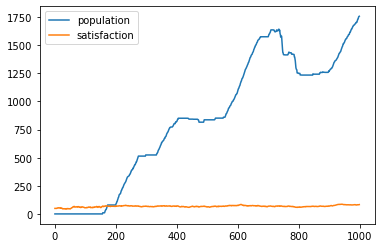

In [7]:
main()